# Rice Production Forecasting Using LSTM

### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Load Dataset

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/algonacci/Free-CDN/main/Beras%20RF.csv")
df

,Komoditas,Luas Panen Padi,GKP Tingkat Petani,GKP Tingkat Penggilingan,GKG Tingkat Penggilingan,Ratarata Beras Penggilingan,Stok GKG Tingkat Penggilingan,Stok Beras Tingkat Penggilingan,Beras,UMP,BBM Solar,quantity
0,2021-03-15,10,4000,4150,5050,9465,20,10,11200,1810351,9600,113151
1,2021-03-16,10,3850,4100,4740,9360,70,20,11200,1810351,9600,113151
2,2021-03-17,10,4160,4230,4950,9400,30,10,11200,1810351,9600,113151
3,2021-03-18,10,4120,4190,4730,9340,40,10,11200,1810351,9600,113151
4,2021-03-19,10,4190,4290,4990,9410,40,10,11200,1810351,9600,113151
...,...,...,...,...,...,...,...,...,...,...,...,...
728,2024-03-11,10,6760,7140,8330,14910,120,80,15800,2057495,6800,113151
729,2024-03-12,10,6530,6930,8260,14810,120,80,15800,2057495,6800,113151
730,2024-03-13,10,6480,6920,8240,14750,100,60,15750,2057495,6800,113151
731,2024-03-14,10,6510,7060,8240,14780,150,70,15750,2057495,6800,113151


### Preprocessing

In [3]:
df['Komoditas'] = pd.to_datetime(df['Komoditas'])
df['Year'] = df['Komoditas'].dt.year
df['Month'] = df['Komoditas'].dt.month

In [4]:
df = df.set_index('Komoditas')
df = df[['Beras']]
df.head()

,Beras
Komoditas,
2021-03-15,11200
2021-03-16,11200
2021-03-17,11200
2021-03-18,11200
2021-03-19,11200


# Data Normalization & Train Test Split

In [5]:
from sklearn.preprocessing import MinMaxScaler
#normalize
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
#split data
train_size = int(len(df_scaled) * 0.8)
train_data, test_data = df_scaled[:train_size], df_scaled[train_size:]


In [6]:
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range (len(data) - sequence_length):
        x.append(data[i:(i + sequence_length), 0])
        y.append(data[i + sequence_length, 0])
    return np.array(x), np.array(y)
sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Modelling

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=150, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss ='mean_squared_error')
model.fit(X_train, y_train, epochs=15, batch_size=64)

Epoch 1/15
9/9 [==============================] - 5s 35ms/step - loss: 0.0085
Epoch 2/15
9/9 [==============================] - 0s 38ms/step - loss: 0.0011
Epoch 3/15
9/9 [==============================] - 0s 33ms/step - loss: 5.7547e-04
Epoch 4/15
9/9 [==============================] - 0s 31ms/step - loss: 3.1975e-04
Epoch 5/15
9/9 [==============================] - 0s 33ms/step - loss: 2.5609e-04
Epoch 6/15
9/9 [==============================] - 0s 34ms/step - loss: 1.7303e-04
Epoch 7/15
9/9 [==============================] - 0s 32ms/step - loss: 1.6159e-04
Epoch 8/15
9/9 [==============================] - 0s 33ms/step - loss: 1.5017e-04
Epoch 9/15
9/9 [==============================] - 0s 34ms/step - loss: 1.4834e-04
Epoch 10/15
9/9 [==============================] - 0s 33ms/step - loss: 1.4598e-04
Epoch 11/15
9/9 [==============================] - 0s 31ms/step - loss: 1.4599e-04
Epoch 12/15
9/9 [==============================] - 0s 32ms/step - loss: 1.4565e-04
Epoch 13/15
9/9 [====

# Actual Rice Production vs Predicted Rice Production

5/5 [==============================] - 2s 9ms/step
Mean Squared Error: 49500.49627647261


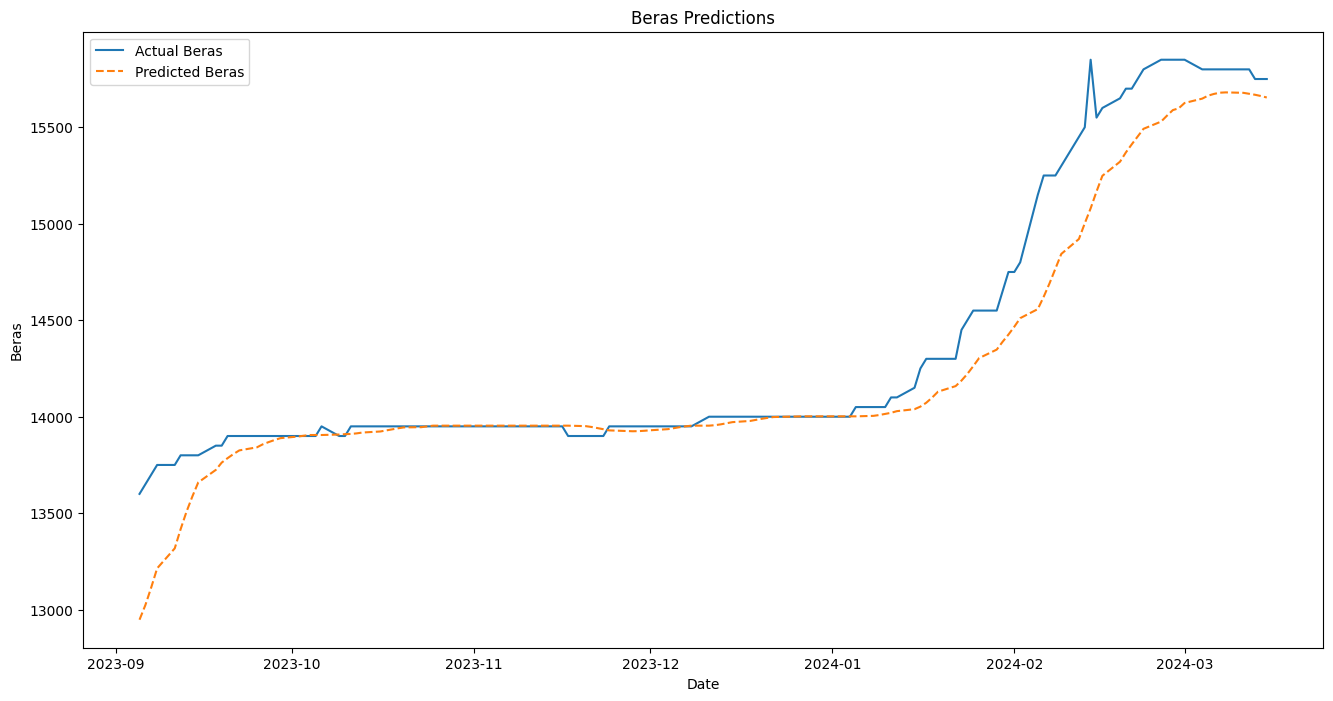

In [8]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1,1))

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df[-len(predictions):]["Beras"], predictions)
print(f'Mean Squared Error: {mse}')
#plot
plt.figure(figsize=(16,8))
plt.plot(df.index[-len(predictions):], df[-len(predictions):]["Beras"], label = "Actual Beras")
plt.plot(df.index[-len(predictions):], predictions, label = "Predicted Beras", linestyle='dashed')
plt.title('Beras Predictions')
plt.xlabel('Date')
plt.ylabel('Beras')
plt.legend()
plt.show()

# Forecasting Future Rice Productions

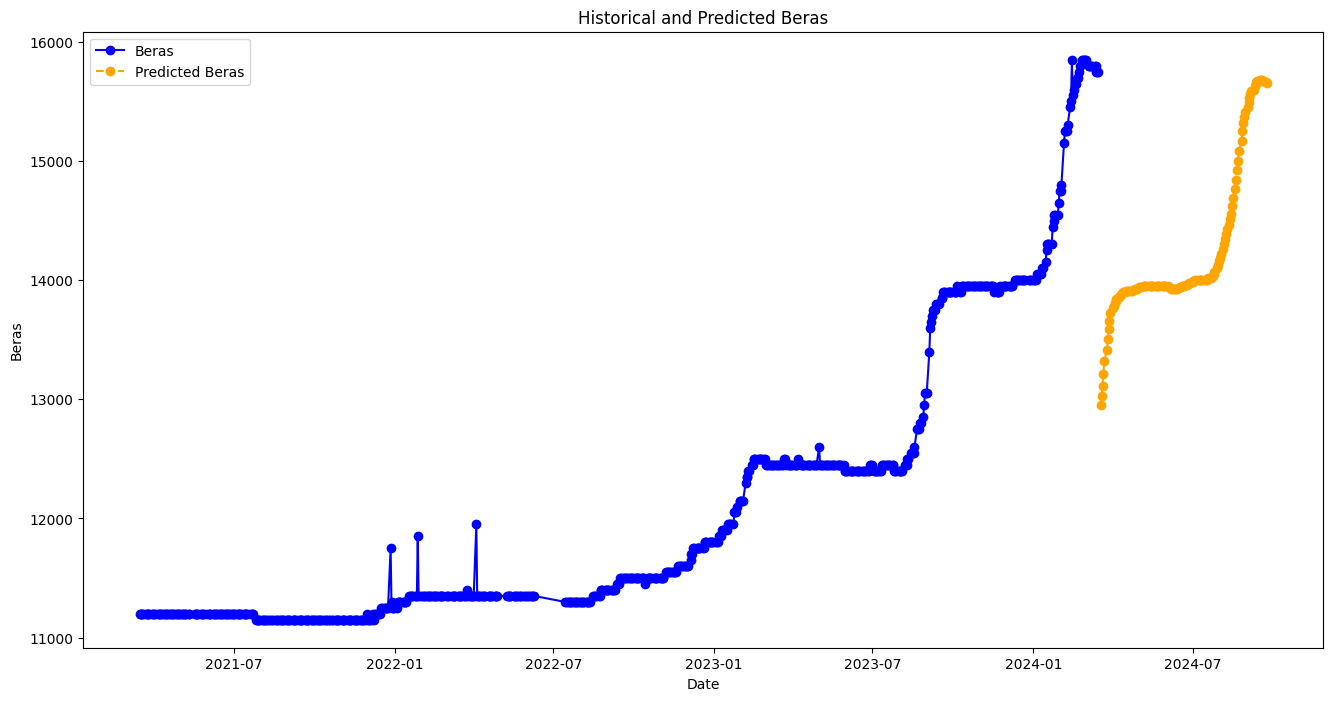

In [9]:
Beras_column = 'Beras'

plt.figure(figsize=(16,8))
plt.plot(df.index, df[Beras_column], label='Beras', marker='o', linestyle='-', color='b')

predicted_dates = pd.date_range(start=df.index[-1], periods=len(predictions)+1, freq='B')[1:]
plt.plot(predicted_dates, predictions, label='Predicted Beras', marker='o', linestyle='dashed', color='orange')
plt.title('Historical and Predicted Beras')
plt.xlabel('Date')
plt.ylabel('Beras')
plt.legend()
plt.show()